In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("card_transdata.csv")
df = df[((df["used_chip"] == 0) & (df["used_pin_number"] == 0) == False)].reset_index()
df.head()

,index,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
2,4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
3,7,4.848247,0.320735,1.273050,1.0,0.0,1.0,0.0,0.0
4,10,14.263530,0.158758,1.136102,1.0,1.0,0.0,1.0,0.0


In [12]:
round(df.corr(), 4)

,index,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
index,1.0000,-0.0028,0.0024,0.0018,-0.0014,0.0032,-0.0037,-0.0030,0.0021
distance_from_home,-0.0028,1.0000,-0.0003,-0.0030,0.1463,0.0017,-0.0018,0.0002,0.0257
distance_from_last_transaction,0.0024,-0.0003,1.0000,0.0019,0.0003,0.0025,-0.0020,0.0023,0.0322
ratio_to_median_purchase_price,0.0018,-0.0030,0.0019,1.0000,0.0023,0.0008,0.0013,-0.0032,0.4902
repeat_retailer,-0.0014,0.1463,0.0003,0.0023,1.0000,-0.0021,-0.0002,0.0010,-0.0050
used_chip,0.0032,0.0017,0.0025,0.0008,-0.0021,1.0000,-0.7658,-0.0010,0.0962
used_pin_number,-0.0037,-0.0018,-0.0020,0.0013,-0.0002,-0.7658,1.0000,-0.0006,-0.1289
online_order,-0.0030,0.0002,0.0023,-0.0032,0.0010,-0.0010,-0.0006,1.0000,0.1579
fraud,0.0021,0.0257,0.0322,0.4902,-0.0050,0.0962,-0.1289,0.1579,1.0000


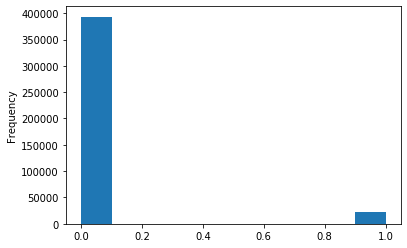

In [13]:
df["fraud"].plot.hist()

In [14]:
def conditional(col):
    copy = df.copy()
    copy[col] = copy[col].astype(int).astype(str)
    copy["fraud"] = copy["fraud"].astype(int).astype(str)
    table = pd.crosstab(copy["fraud"], copy[col]).divide(copy[col].value_counts())
    return round(table, 3)

In [15]:
df["medianDistanceHome"] = df["distance_from_home"] >= df["distance_from_home"].median()
df["medianDistanceTransaction"] = df["distance_from_last_transaction"] >= df["distance_from_last_transaction"].median()
df["medianPriceRatio"] = df["ratio_to_median_purchase_price"] >= df["ratio_to_median_purchase_price"].median()

columns = ["repeat_retailer", "used_chip", "used_pin_number", "online_order", "medianDistanceHome", "medianDistanceTransaction", "medianPriceRatio"]
for c in columns:
    table = conditional(c)
    print(table)
    print("\n")
    table.to_csv(f"{c}_conditional.csv")

           0      1
fraud              
0      0.942  0.946
1      0.058  0.054


           0      1
fraud              
0      0.996  0.936
1      0.004  0.064


used_pin_number      0      1
fraud                        
0                0.929  0.997
1                0.071  0.003


           0      1
fraud              
0      0.994  0.919
1      0.006  0.081


           0      1
fraud              
0      0.946  0.945
1      0.054  0.055


           0      1
fraud              
0      0.947  0.944
1      0.053  0.056


           0      1
fraud              
0      0.999  0.892
1      0.001  0.108




In [16]:
import math
import scipy.stats as stats

def two_proportion_z_test(x1, n1, x2, n2):
    p1 = x1 / n1
    p2 = x2 / n2

    p_combined = (x1 + x2) / (n1 + n2)
    standard_error = math.sqrt(p_combined * (1 - p_combined) * ((1 / n1) + (1 / n2)))

    z_score = (p1 - p2) / standard_error

    # Calculate the p-value
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))  # Two-tailed test

    return p_value



#p_value = two_proportion_z_test(x1, n1, x2, n2)
#print("p-value:", p_value)

Testing Two-proportion z for each column.

H0: There is no difference in fraud rate for usage of each metric.
HA: There is a difference ... non-usage.

In [17]:
def z_test(item):
    xYes = len(df[(df[item] == 1) & (df["fraud"] == 1)])
    nYes = len(df[df[item] == 1])

    # no chip
    xNo = len(df[(df[item] == 0) & (df["fraud"] == 1)])
    nNo = len(df[df[item] == 0])
    return two_proportion_z_test(xYes, nYes, xNo, nNo)

In [18]:
for c in columns:
    print(f"z_test for {c} on fraud prediction: p-value = {round(z_test(c), 4)}")

z_test for repeat_retailer on fraud prediction: p-value = 0.0011
z_test for used_chip on fraud prediction: p-value = 0.0
z_test for used_pin_number on fraud prediction: p-value = 0.0
z_test for online_order on fraud prediction: p-value = 0.0
z_test for medianDistanceHome on fraud prediction: p-value = 0.2189
z_test for medianDistanceTransaction on fraud prediction: p-value = 0.0
z_test for medianPriceRatio on fraud prediction: p-value = 0.0


In [19]:
import math
import scipy.stats as stats

def two_proportion_z_test_relative_risk(x1, n1, x2, n2):
    p1 = x1 / n1
    p2 = x2 / n2

    relative_risk = p1 / p2

    standard_error = math.sqrt(((1 - p1) / (n1 * p1)) + ((1 - p2) / (n2 * p2)))

    z_score = math.log(relative_risk) / standard_error

    # Calculate the p-value
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))  # Two-tailed test

    return p_value

In [20]:
def rr_test(item):
    xYes = len(df[(df[item] == 1) & (df["fraud"] == 1)])
    nYes = len(df[df[item] == 1])

    # no chip
    xNo = len(df[(df[item] == 0) & (df["fraud"] == 1)])
    nNo = len(df[df[item] == 0])
    return two_proportion_z_test_relative_risk(xYes, nYes, xNo, nNo)

In [21]:
for c in columns:
    print(f"z_test RR for {c} on fraud prediction: p-value = {round(z_test(c), 4)}")

z_test RR for repeat_retailer on fraud prediction: p-value = 0.0011
z_test RR for used_chip on fraud prediction: p-value = 0.0
z_test RR for used_pin_number on fraud prediction: p-value = 0.0
z_test RR for online_order on fraud prediction: p-value = 0.0
z_test RR for medianDistanceHome on fraud prediction: p-value = 0.2189
z_test RR for medianDistanceTransaction on fraud prediction: p-value = 0.0
z_test RR for medianPriceRatio on fraud prediction: p-value = 0.0


## Confidence intervals:

In [22]:
def ci95(item):
    xYes = len(df[(df[item] == 1) & (df["fraud"] == 1)])
    nYes = len(df[df[item] == 1])

    xNo = len(df[(df[item] == 0) & (df["fraud"] == 1)])
    nNo = len(df[df[item] == 0])
    
    RR = (xYes/nYes)/(xNo/nNo)
    SE = math.sqrt(((nYes - xYes)/xYes) / nYes + ((nNo - xNo)/xNo) / nNo)
    left = min(math.log(RR)/math.log(math.e) + 1.96*SE, math.log(RR)/math.log(math.e) - 1.96*SE)
    right = max(math.log(RR)/math.log(math.e) + 1.96*SE, math.log(RR)/math.log(math.e) - 1.96*SE)
    return (round(math.exp(left), 3), round(math.exp(right), 3))

In [24]:
for c in columns:
    print(f"95% CI for {c}: {round(ci95(c), 3)}")

TypeError: type tuple doesn't define __round__ method